In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import os
import time as tm
import pypolo2

# Environment

In [2]:
Setting = pypolo2.utilities.Config()

In [3]:
dir = "./data/MyProData/Total1123.csv"
# 初始时间数据选择从数据中读取的初始状态，选取11月23日
#读取数据
df_env = pd.read_csv(dir)
df_env_timeindex = df_env.set_index('time')

base_time = pd.Timestamp('2018-11-23 00:00:00')

time = Setting.starttime

# 选择时间段
start_time = pd.Timestamp(time)
end_time = pd.Timestamp(time)

#计算时间点
df_env['time_int'] = df_env['time'].apply(lambda x: round((pd.Timestamp(x) - base_time).total_seconds() / 60 / 10))

# 将 time 字段转换为 Pandas 中的 Timestamp 类型
df_env['time'] = pd.to_datetime(df_env['time'], format="%Y-%m-%d %H:%M:%S")

# 从 DataFrame 中选择符合时间段的数据
mask = (df_env['time'] >= start_time) & (df_env['time'] <= end_time)
selected_data = df_env.loc[mask]

data_x_env = selected_data.loc[:, ['lat_bin', 'lon_bin', 'time_int', 'time']].values
data_y_env = selected_data.loc[:, ['pm2d5', 'time_int', 'time']].values

data_x = data_x_env[:,0:3]
data_y = data_y_env[:,0]

data_x[:,2] = data_x[:,2]*Setting.time_co

In [4]:
data_x_onemoment = data_x[:,0:2]

In [5]:
# Setting.time_stamp = data_x[:,2].max(axis=0, keepdims=False)
initdata_kernel = pypolo2.kernels.RBF(Setting)
initdata_model = pypolo2.models.GPR(
    x_train=data_x_onemoment.astype(np.float64),
    y_train=data_y.reshape(-1,1).astype(np.float64),
    kernel=initdata_kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)
initdata_model.optimize(num_iter=initdata_model.num_train, verbose=True)

Iter: 37 loss:  53.95: 100%|██████████| 38/38 [00:00<00:00, 311.69it/s]


In [6]:
# 根据拟合的数据，提取出整个环境的拟合分布
allstate_list = []
for i in range (Setting.task_extent[0],Setting.task_extent[1]):
    for j in range (Setting.task_extent[2],Setting.task_extent[3]):
        allstate_list.append([i, j])
allstate = np.array(allstate_list)
#compute predict mean and sprink_effect of all point
mean, _ = initdata_model(allstate)
pred = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
for i in range (Setting.task_extent[0],Setting.task_extent[1]):
    for j in range (Setting.task_extent[2],Setting.task_extent[3]):
        pred[i,j] = mean[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]

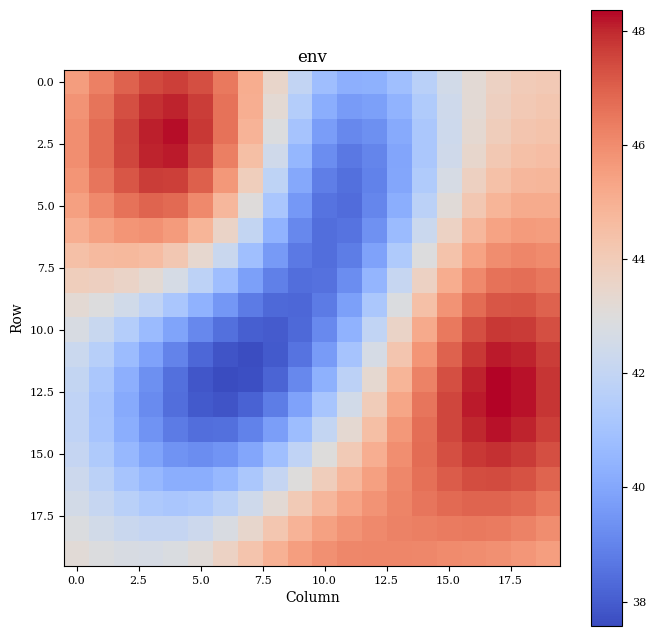

In [7]:
# Create two subplots for env_list and mi_list heatmaps
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('env')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
# Set axis limits for both subplots
ax.axis([-0.5, 19.5, -0.5, 19.5])
# Invert y-axis for both subplots
ax.invert_yaxis()
# Create heatmap objects for both subplots
heatmap3 = pred
im3 = ax.imshow(heatmap3, cmap=cm.coolwarm, interpolation='nearest', origin='lower')
# Add colorbars to both subplots
cbar3 = fig.colorbar(im3, ax=ax)
# Define the size of the triangles
size = 0.3

In [8]:
# 使用数据作为初始状态
Setting.env = pred

# Evaluator & Logger

In [9]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = './outputs/{}/releaserate_{}'.format(Setting.strategy_name,"%03d" %(Setting.delta_t*100))
Savename = 'seed{}_starttime{}'.format(Setting.seed, starttime)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [10]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Initual Sensing Data

In [11]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


In [12]:
env_model = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

#固定站的观测的观测
for time in range(Setting.time_before_sche):
    y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*Setting.time_co
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-10+1)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    time_init[time] = (time+1)*Setting.time_co
    Setting.env = env_model.solve((1+Setting.station_size+time)*Setting.delta_t)
    sensor.set_env(Setting.env)

Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

100%|██████████| 0.3/0.3 [00:00<00:00,  2.05s/it]    
100%|██████████| 0.6/0.6 [00:00<00:00, 16.94it/s]    


# Model

In [13]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [14]:
kernel = pypolo2.kernels.RBF(Setting)

In [15]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [16]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 01 loss:  3.03: 100%|██████████| 2/2 [00:00<00:00, 331.30it/s]


# Agent

In [17]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.VEHICLE(
        init_state=np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        water_volume=Setting.water_volume
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [18]:
strategy = pypolo2.strategies.NonMyopicLatticePlanningMISprinkler(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [19]:
#定义需要随时间更新的训练过程
def run2(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    total_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    change_step = 0 # 污染源变化间隔
    spray_effect = 0 # 洒水效果
    while total_step < Setting.max_num_samples:
        # scheduling
        result, MI_information, observed_env, computed_effect = strategy.get(model = model, Setting = Setting)
        
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(total_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
        
        # update agent goals
        if adaptive_step >= Setting.adaptive_step:
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1],Setting.water_station)
                
        # change source
        if change_step >= Setting.R_change_interval:
            change_step = 0
            Setting.R = np.zeros((Setting.grid_x, Setting.grid_y)) + 4# initialize pollution resource map matrix
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 19, size=4)
                pairs = rng.choice(numbers, size=(2, 2), replace=False)
                for i in range(2):
                    number = rng.randint(500, 1000, size=1)
                    Setting.R[pairs[i,0]][pairs[i,1]] = number
            else:
                Setting.R[10][10] = 2000
                # Setting.R[1][10] = 1300
                # Setting.R[10][1] = 1300
                # Setting.R[18][10] = 1300
                # Setting.R[10][18] = 1300
                Setting.R[2][2] = 1000
                Setting.R[17][17] = 1000
                Setting.R[17][2] = 1000
                Setting.R[2][17] = 1000
                
        # update state
        x_new = []
        y_new = []
        spray_effect = 0
        for id, vehicle in vehicle_team.items():
            vehicle.update_withoutreplenishment()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            #spray and calculate spray effect
            if Setting.strategy_name != "forestfire_Without_Operation":
                Setting.env, effect = sensor.spray(current_state, vehicle.spray_flag, Setting.task_extent)
                spray_effect = spray_effect + effect
            # y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
        if Setting.Env == "Dynamic":
            env_model = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
            Setting.env = env_model.solve(Setting.delta_t)
            sensor.set_env(Setting.env)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1    
        total_step = total_step + 1
        change_step = change_step + 1

In [ ]:
start = tm.time()
run2(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
logger.save(end-start)  # I temporarily removed "makefile()".

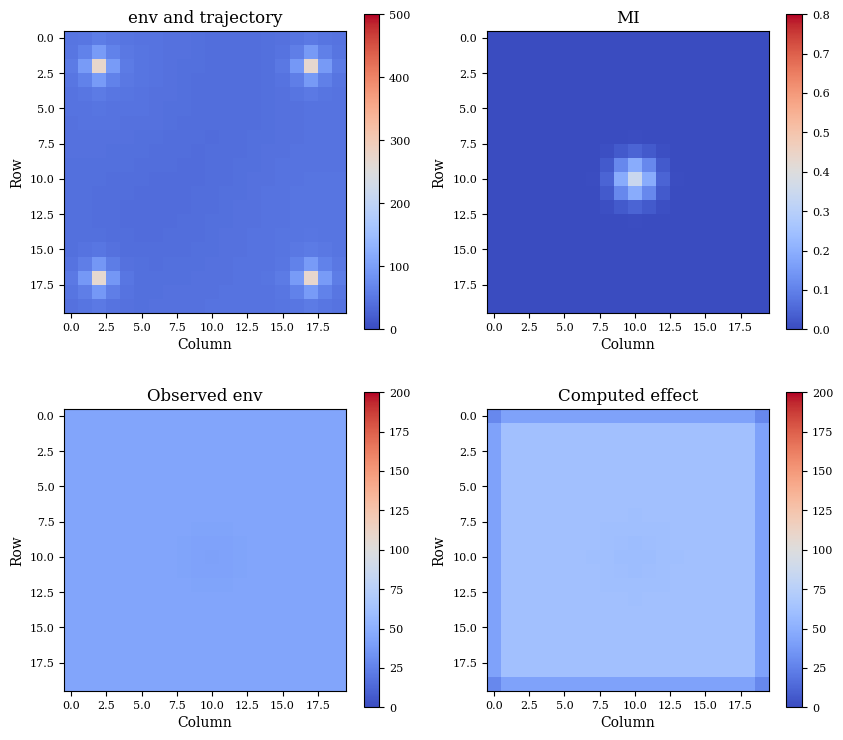

In [21]:
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import interpolate
import matplotlib.animation
import matplotlib.cm as cm
import matplotlib.colors as colors

fig, axs = plt.subplots(2, 2, figsize=(10, 9))
ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

ax1.set_title('env and trajectory')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')

ax2.set_title('MI')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')

ax3.set_title('Observed env')
ax3.set_xlabel('Column')
ax3.set_ylabel('Row')

ax4.set_title('Computed effect')
ax4.set_xlabel('Column')
ax4.set_ylabel('Row')

# Set axis limits for both subplots
ax1.axis([-0.5, 19.5, -0.5, 19.5])
ax2.axis([-0.5, 19.5, -0.5, 19.5])
ax3.axis([-0.5, 19.5, -0.5, 19.5])
ax4.axis([-0.5, 19.5, -0.5, 19.5])

# Invert y-axis for both subplots
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()

# Create heatmap objects for both subplots
heatmap1 = logger.save_data['truth_env'][0]
heatmap2 = logger.save_data['MI_information'][0]
heatmap3 = logger.save_data['observed_env'][0]
heatmap4 = logger.save_data['computed_effect'][0]

im1 = ax1.imshow(heatmap1, cmap=cm.coolwarm, interpolation='nearest', origin='lower')
im2 = ax2.imshow(heatmap2, cmap=cm.coolwarm, interpolation='nearest', origin='lower')
im3 = ax3.imshow(heatmap3, cmap=cm.coolwarm, interpolation='nearest', origin='lower')
im4 = ax4.imshow(heatmap4, cmap=cm.coolwarm, interpolation='nearest', origin='lower')

# Add colorbars to both subplots
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar3 = fig.colorbar(im3, ax=ax3)
cbar4 = fig.colorbar(im4, ax=ax4)

# Plot the initial trajectory on the third subplot
l_list = []
arr = dict()
for id in range(logger.save_data['info']['team_size']):
    arr[id+1] = []
for step in range(len(logger.save_data['time_series'])):
    for id in range(len(logger.save_data['time_series'][step]['state'])):
        state = logger.save_data['time_series'][step]['state'][id+1]
        arr[id+1].append(state)
for id in range(logger.save_data['info']['team_size']):     
    arr[id+1] = np.array(arr[id+1])
    l, = ax1.plot([],[], color='black', linewidth=1)
    l_list.append(l)

# Define animate function for both subplots
def animate(i):
    heatmap1 = logger.save_data['truth_env'][i]
    heatmap2 = logger.save_data['MI_information'][i]
    heatmap3 = logger.save_data['observed_env'][i]
    heatmap4 = logger.save_data['computed_effect'][i]
    
    im1.set_data(heatmap1)
    im2.set_data(heatmap2)
    im3.set_data(heatmap3)
    im4.set_data(heatmap4)
    
    # Adjust the color range of the heatmap
    im1.set_clim(vmin=0, vmax=500)
    im2.set_clim(vmin=0, vmax=0.8)
    im3.set_clim(vmin=0, vmax=200)
    im4.set_clim(vmin=0, vmax=200)
    
    for id in range(logger.save_data['info']['team_size']):
        traj = arr[id+1]
        # Extract the x-coordinates and y-coordinates up to time i
        x = traj[:i+1, 0]
        y = traj[:i+1, 1]
        # Update the trajectory with the current x and y coordinates
        l_list[id-1].set_data(y, x)

    return im1, im2, im3, im4, l_list

# Create animation object for both subplots
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = Setting.max_num_samples-1)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())